In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
import io
from scipy.spatial.distance import cdist

/tmp/ipykernel_30/2258806266.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(io.BytesIO(response.content))


dict_keys(['data', 'targets'])
(2500, 32, 32, 3)
(2500,)


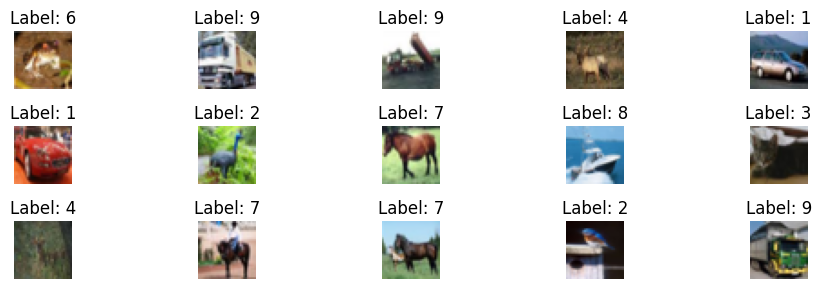

In [10]:

# Download and load the train dataset
train_path = 'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_one_dataset/train_data/1_train_data.tar.pth'
response = requests.get(train_path, stream=True)
response.raise_for_status()  # Raise an exception for bad responses
train_data = torch.load(io.BytesIO(response.content))

print(train_data.keys())
print(train_data['data'].shape)
print(train_data['targets'].shape)

# Display first 15 images and labels
images = train_data['data'][:15]
labels = train_data['targets'][:15]

fig, axes = plt.subplots(3, 5, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')  # Hide the axes for a cleaner look
plt.tight_layout()
plt.show()

In [11]:
# Dataset class for processing
class ImageDataProcessor(Dataset):
    def __init__(self, images, labels=None, preprocess=None):
        self.images = images
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.fromarray(self.images[index])  # Convert to PIL Image
        lbl = self.labels[index] if self.labels is not None else -1  # Default label is -1
        if self.preprocess:
            img = self.preprocess(img)
        return img, lbl

# Define preprocessing pipeline
image_transforms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Updated initialize_feature_extractor
def initialize_feature_extractor():
    resnet152 = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
    extractor = torch.nn.Sequential(*list(resnet152.children())[:-1])  # Remove classification layer
    extractor.eval()  # Set to evaluation mode
    return extractor.to(device)  # Move to GPU if available


# Updated generate_embeddings
def generate_embeddings(model, dataloader):
    all_features, all_labels = [], []
    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(device)  # Move images to GPU
            batch_labels = batch_labels.to(device)  # Move labels to GPU
            batch_features = model(batch_images).squeeze()
            all_features.append(batch_features.cpu())  # Move back to CPU for concatenation
            all_labels.append(batch_labels.cpu())  # Move back to CPU for concatenation
    return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0)

# Classifier using prototypes
class LwPClassifier:
    def __init__(self, metric='euclidean'):
        self.metric = metric
        self.class_prototypes = {}

    def fit(self, X, y):
        X = X.reshape(X.shape[0], -1)
        X = torch.tensor(X, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)  # Move labels to GPU
        prototypes = torch.stack([X[y == cls].mean(dim=0) for cls in torch.unique(y)])
        self.class_prototypes = {cls.item(): prototypes[idx] for idx, cls in enumerate(torch.unique(y))}

    def predict(self, X):
        X = X.reshape(X.shape[0], -1)
        X = torch.tensor(X, dtype=torch.float32).to(device)
        prototypes = torch.stack(list(self.class_prototypes.values())).to(device)
        distances = cdist(X.cpu(), prototypes.cpu(), metric=self.metric)
        closest_prototype_idx = distances.argmin(axis=1)
        return np.array(list(self.class_prototypes.keys()))[closest_prototype_idx]

In [12]:
# Prepare data
num_models = 20
train_data_extracted = {}
eval_data_extracted = {}
labels_train = {}
labels_eval = {}

feature_extractor = initialize_feature_extractor()

# Process train datasets
for i in range(1, num_models + 1):
    print(f"Processing training dataset {i}")
    train_path = f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_one_dataset/train_data/{i}_train_data.tar.pth' if i <= 10 else \
                 f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_two_dataset/train_data/{i-10}_train_data.tar.pth'
    response = requests.get(train_path, stream=True)
    train_data = torch.load(io.BytesIO(response.content))

    X_train = train_data['data']
    Y_train = train_data.get('targets')  # Only available for training dataset 1
    dataset = ImageDataProcessor(X_train, Y_train, preprocess=image_transforms)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    X_train_features, Y_train_fallback = generate_embeddings(feature_extractor, loader)
    train_data_extracted[i] = X_train_features.numpy()
    labels_train[i] = Y_train_fallback if Y_train is not None else Y_train_fallback  # Use fallback labels for dataset 1

# Process eval datasets
for i in range(1, num_models + 1):
    print(f"Processing evaluation dataset {i}")
    eval_path = f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_one_dataset/eval_data/{i}_eval_data.tar.pth' if i <= 10 else \
                f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_two_dataset/eval_data/{i-10}_eval_data.tar.pth'
    response = requests.get(eval_path, stream=True)
    eval_data = torch.load(io.BytesIO(response.content))
    X_valid, Y_valid = eval_data['data'], eval_data['targets']
    dataset = ImageDataProcessor(X_valid, Y_valid, preprocess=image_transforms)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    X_valid_features, Y_valid = generate_embeddings(feature_extractor, loader)
    eval_data_extracted[i] = X_valid_features.numpy()
    labels_eval[i] = Y_valid

Processing training dataset 1


/tmp/ipykernel_30/1956189205.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(io.BytesIO(response.content))


Processing training dataset 2
Processing training dataset 3
Processing training dataset 4
Processing training dataset 5
Processing training dataset 6
Processing training dataset 7
Processing training dataset 8
Processing training dataset 9
Processing training dataset 10
Processing training dataset 11
Processing training dataset 12
Processing training dataset 13
Processing training dataset 14
Processing training dataset 15
Processing training dataset 16
Processing training dataset 17
Processing training dataset 18
Processing training dataset 19
Processing training dataset 20
Processing evaluation dataset 1


/tmp/ipykernel_30/1956189205.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_data = torch.load(io.BytesIO(response.content))


Processing evaluation dataset 2
Processing evaluation dataset 3
Processing evaluation dataset 4
Processing evaluation dataset 5
Processing evaluation dataset 6
Processing evaluation dataset 7
Processing evaluation dataset 8
Processing evaluation dataset 9
Processing evaluation dataset 10
Processing evaluation dataset 11
Processing evaluation dataset 12
Processing evaluation dataset 13
Processing evaluation dataset 14
Processing evaluation dataset 15
Processing evaluation dataset 16
Processing evaluation dataset 17
Processing evaluation dataset 18
Processing evaluation dataset 19
Processing evaluation dataset 20


In [13]:
print(train_data_extracted[1].shape)

(2500, 2048)


In [14]:

# Initialize classifier and train on the first dataset
classifier = LwPClassifier(metric='euclidean')
classifier.fit(train_data_extracted[1], labels_train[1])

# Evaluate on the first dataset
valid_predictions_1 = classifier.predict(eval_data_extracted[1])
valid_accuracy_1 = accuracy_score(labels_eval[1], valid_predictions_1)
accuracy_matrix = np.zeros((num_models, num_models))
accuracy_matrix[0, 0] = valid_accuracy_1
print(f"Model f1: Validation Accuracy on D1 = {valid_accuracy_1:.2f}")

Model f1: Validation Accuracy on D1 = 0.90


/tmp/ipykernel_30/1219413002.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long).to(device)  # Move labels to GPU


In [15]:

# Train and evaluate models on subsequent datasets
for i in range(2, num_models+1):
    X_train = train_data_extracted[i]

    # Generate pseudo-labels and update prototypes
    pseudo_labels = classifier.predict(X_train)
    X_combined = X_train
    Y_combined = pseudo_labels
    classifier.fit(X_combined, Y_combined)  # Update prototypes with combined data

    # Evaluate the current model on the current and all previous validation sets
    for j in range(1, i + 1):
        X_valid_j = eval_data_extracted[j]
        Y_valid_j = labels_eval[j]

        valid_predictions = classifier.predict(X_valid_j)
        valid_accuracy = accuracy_score(Y_valid_j, valid_predictions)
        accuracy_matrix[i - 1, j - 1] = valid_accuracy

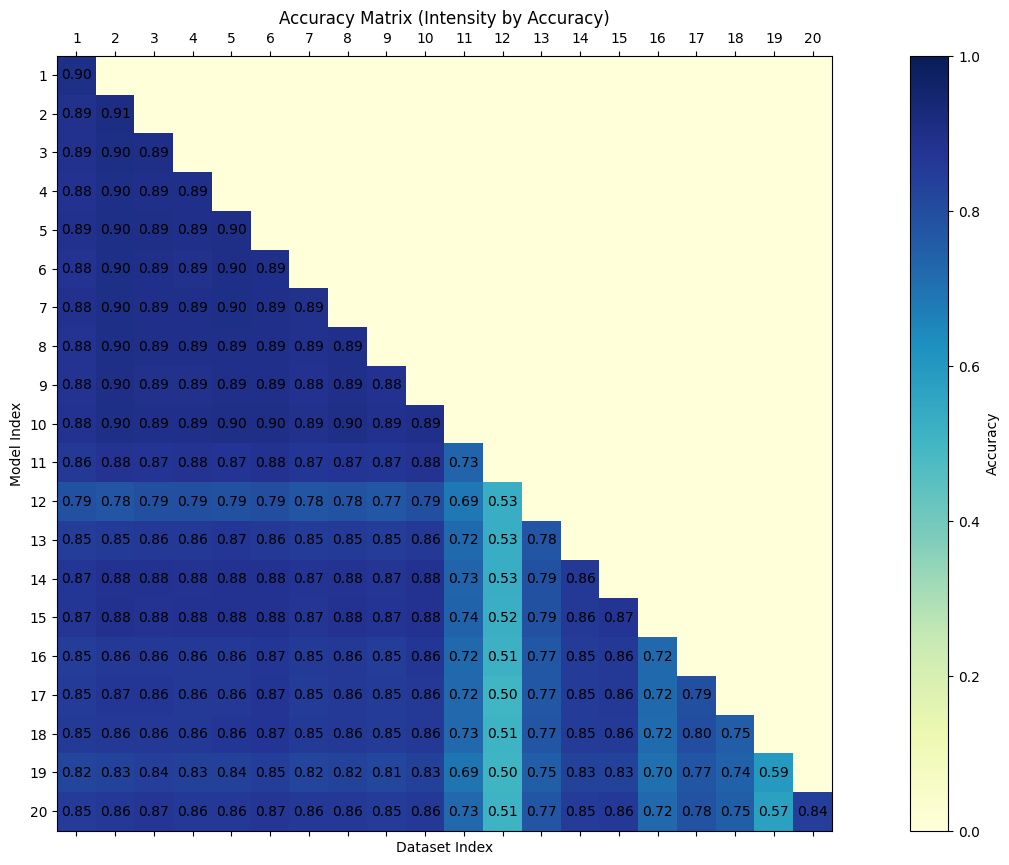

In [16]:
# Plotting the accuracy matrix as a heatmap
plt.figure(figsize=(20, 10))
heatmap = plt.matshow(accuracy_matrix, cmap='YlGnBu', fignum=1, vmin=0, vmax=1.0)  # Set color range from 0.6 to 1.0

# Add color bar for reference with accuracy label
plt.colorbar(heatmap, label='Accuracy')

# Add annotations to each cell with the accuracy values
for i in range(num_models):
    for j in range(i + 1):  # Only show lower triangle values
        plt.text(j, i, f"{accuracy_matrix[i, j]:.2f}", ha='center', va='center', color="black")

# Adjust tick labels to start from 1 instead of 0
plt.xticks(ticks=range(num_models), labels=range(1, num_models + 1))
plt.yticks(ticks=range(num_models), labels=range(1, num_models + 1))

# Set axis labels
plt.xlabel("Dataset Index")
plt.ylabel("Model Index")
plt.title("Accuracy Matrix (Intensity by Accuracy)")

# Show the plot
plt.show()